In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import random

# Download data

In [ ]:
# Fetch MNIST dataset
from sklearn.datasets import fetch_openml

# data_set = 'mnist'
data_set = 'fashion_mnist'

if data_set == 'mnist':
  raw_data = fetch_openml('mnist_784')
  raw_data_x = np.array((raw_data['data']+0.5)/256.0)
  raw_data_y = np.array(raw_data['target'].astype('int8'))
  num_classes = 10
  img_sz = (28,28)
elif data_set == 'fashion_mnist':
  raw_data = fetch_openml('Fashion-MNIST')
  raw_data_x = np.array((raw_data['data']+0.5)/256.0)
  raw_data_y = np.array(raw_data['target'].astype('int8'))
  num_classes = 10
  img_sz = (28,28)
else:
  assert False

data_dim = raw_data_x.shape[1]

## Split data into training and validation

In [ ]:
def display_image(x,lbl=None):
  plt.imshow(x.reshape(img_sz))
  plt.xticks([])
  plt.yticks([])
  if lbl is not None:
    plt.title(lbl)

def split_data(x,y,fracs=[0.8,0.2],seed=0):
  if seed is not None:
    np.random.seed(seed)
  N = x.shape[0]
  rp = np.random.permutation(N)

  N1 = int(fracs[0]*N)
  N2 = min(N-N1,int(fracs[1]*N))

  # Split the data into two parts
  x1 = x[rp[:N1]]
  y1 = y[rp[:N1]]
  x2 = x[rp[N1:(N1+N2)]]
  y2 = y[rp[N1:(N1+N2)]]

  return x1,y1,x2,y2

def onehot_encode(y,num_classes=10):
  """
  Convert an Nx1 vector of integer class labels from 0 to C-1 into 
  an NxC matrix where each row is a one-hot encoding of the 
  """
  return np.eye(num_classes)[y.reshape(-1)]


In [ ]:
train_x,train_y,test_x,test_y = split_data(raw_data_x,raw_data_y,fracs=[0.2,0.2])
train_x,train_y,  val_x,val_y = split_data(train_x,train_y,fracs=[0.6,0.4])

# Explore the data

10.77% of the training data is class 0, corresponding to 905 data points
10.32% of the training data is class 1, corresponding to 867 data points
9.39% of the training data is class 2, corresponding to 789 data points
10.48% of the training data is class 3, corresponding to 880 data points
9.73% of the training data is class 4, corresponding to 817 data points
9.76% of the training data is class 5, corresponding to 820 data points
10.49% of the training data is class 6, corresponding to 881 data points
9.61% of the training data is class 7, corresponding to 807 data points
9.33% of the training data is class 8, corresponding to 784 data points
10.12% of the training data is class 9, corresponding to 850 data points


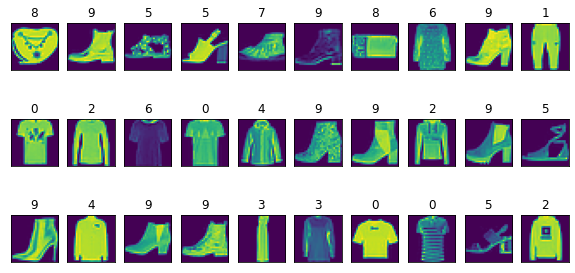

In [ ]:
# Print statistics
num_train = len(train_y)
for i in range(num_classes):
  num_class_i = np.sum(train_y == i)
  print('{:.2f}% of the training data is class {}, corresponding to {} data points'.format(100*num_class_i/num_train,
                                                                                       i, num_class_i))

# Visualize a few images
np.random.seed(0)
num_digits = 10
num_rows = 3
plt.figure(figsize=(10,5))
for i in range(num_rows*num_digits):
  ind = np.random.randint(0,train_x.shape[0])
  plt.subplot(num_rows,num_digits,i+1)
  display_image(train_x[ind,:],
                train_y[ind])



# Implement activation and loss functions and their derivatives

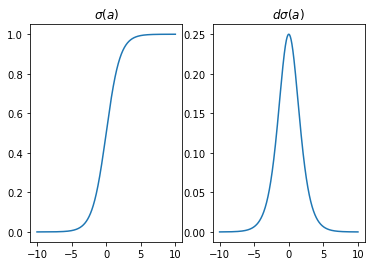

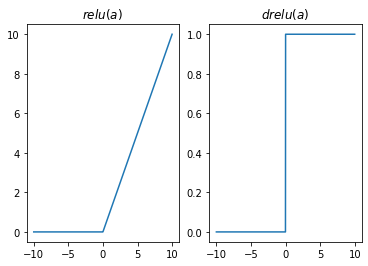

In [ ]:
def sigmoid(a,deriv=False):
  # The sigmoid activation function 1/(1+exp(-a)) and its derivative
  #
  # Input: a - NxC matrix of values where each row of a corresponds to a single
  # input to the current layer with C units.
  # Output: s,ds
  #   s - NxC matrix of sigmoid function evaluated at the values in a
  #  ds - NxC matrix of the derivatives of the sigmoid evaluated at the values of a
  #
  # NOTE: you may only use basic exp/log functions from numpy here.  Only
  # np.exp, np.log, np.log1p, np.log1m, along with basic arithmetic are allowed
  # in your implementation.

  s  = 1/(1.0 + np.exp(-a))

  if deriv:
    ns = 1/(1.0 + np.exp( a))
    ds = s*ns

    return s, ds
  else:
    return s

def relu(a,deriv=False):
  # TODO: Implement the relu activation function max(a,0) and its derivative
  #
  # Input: a - NxC matrix of values where each row of a corresponds to a single
  # input to the current layer with C units.
  # Output: r,dr
  #   r - NxC matrix of function values at the values in a
  #  dr - NxC matrix of the derivatives of the relu evaluated at the values of a
  r = np.maximum(a,0)
 
  dr = np.copy(r)
  dr[dr>0] = 1
  dr[dr<0] = 0
  #dr = np.zeros(a.shape)
  
  #if len(a.shape) == 1:
    #for i in range(len(a)):
      #dr[i] = 1 if r[i] > 0 else 0
  #else:
    #A,B = a.shape
    #for i in range(A):
      #for j in range(B):
        #dr[i][j] = 1 if r[i][j] > 0 else 0
  
  if deriv:
    
    return r, dr
  else:
    return r

def softmax(a,params=None,deriv=False):
  # TODO: Implement the softmax function s = exp(a)/sum(exp(a)) and its
  # Jacobian where J[i,j] = ds[i]/da[j] = -(s[i]*s[j]) if i!=j and
  # (s[i]*(1-s[i])) if i==j.
  #
  # Input: a - NxC matrix of values where each row of a corresponds to a single
  # input to the softmax function
  # Output: s,ds
  #   s - NxC matrix of softmax function values at the values in a
  #  ds - NxCxC tensor of Jacobians of the softmax function of each input

  N,C = a.shape
  s = np.zeros((N,C))
  for i in range(N):
    sum = 0
    local_max = np.max(a[i])
    for j in a[i]:
      sum += np.exp(j-local_max)
    for k in range(len(a[i])):
      s[i][k] = np.exp(a[i][k] - local_max)/sum

  #s = np.zeros((N,C))
  #for i in range(N):
    #maxi = np.max(a[i])
    #sum = 0
    #b = np.exp(a[i]-maxi)
    #sum = np.sum(b)
    #s[i] = np.exp(a[i] - maxi)/sum
  if deriv:
    ds = np.zeros((N,C,C))
    for d in range(N):
      for e in range(C):
        for f in range(C):
          if e == f:
            ds[d][e][f] = s[d][e]*(1-s[d][e])
          else:
            ds[d][e][f] = -s[d][e]*s[d][f]
    return s, ds
  else:
    return s

def identity(a,deriv=False):
  if deriv:
    return a, np.ones_like(a)
  else:
    return a

def crossent(y,yhat,deriv=False):
  # TODO: Implement the cross entropy loss L = -\sum_c (y==c) log(p(y==c)).
  #
  # Input: y,yhat
  #     y - Nx1 vector of class labels for N inputs
  #  yhat - NxC matrix of probabilities of each class c for each input i
  #         i.e., yhat[i,c] is p(y[i]==c)
  #
  # Output: l,dl
  #   l - Nx1 vector of cross entropy values
  #  dl - Nx1xC matrix of derivatives
  N,C = yhat.shape
  if y.shape[0] == N:
    onehot = onehot_encode(y,num_classes=10)
    l = np.zeros(N)
    for a in range(N):
      sum = 0
      for b in range(C):
        sum -= onehot[a][b]*np.log(yhat[a][b])
      l[a] = sum
  if deriv:
    dl = yhat - onehot

    return l,dl
  else:
    return l

def test_acts_impl():
  # These are sanity checks, not exhaustive unit tests.  These may pass but you
  # may still have bugs.  However, if these don't pass you almost certainly have
  # bugs.

  import scipy.special as spsp

  acts = [sigmoid,relu,softmax,identity]
  N = 2
  D = 5
  eps = 1e-8
  for _ in range(5):
    aval0 = np.random.randn(N,D)
    for afunc in acts:
      fval, dfval = afunc(aval0,deriv=True)
      #print(afunc) # uncomment this line to see which activation function is failing
      for i in range(D):
        aval_m = np.copy(aval0)
        aval_m[:,i] -= eps
        aval_p = np.copy(aval0)
        aval_p[:,i] += eps
        dfval_fd = (afunc(aval_p) - afunc(aval_m))/(2*eps)
        if dfval.ndim == 3:
          assert np.allclose(dfval_fd,dfval[:,:,i])
        else:
          assert np.allclose(dfval_fd[:,i],dfval[:,i])
  
  # unit test the sigmoid function
  eps = 1e-8
  avals = [-5,0.1,1]
  for a in avals:
    sa = sigmoid(a)

    assert np.all(sa > 0)
    assert np.all(sa < 1)
    assert np.abs(sa - spsp.expit(a)) < 1e-8

  # unit test the softmax function
  N = 2
  D = 5
  eps = 1e-8
  logitval0 = np.random.randn(N,D)
  s0 = softmax(logitval0)
  assert np.all(s0 >= 0)
  assert np.all(np.abs(1-np.sum(s0,axis=1))<1e-8)


  ina = np.linspace(-10,10,1000)
  plt.figure()
  plt.subplot(1,2,1)
  plt.plot(ina,sigmoid(ina,deriv=False))
  plt.title('$\sigma(a)$')
  plt.subplot(1,2,2)
  plt.plot(ina,sigmoid(ina,deriv=True)[1])
  plt.title('$d \sigma(a)$')

  ina = np.linspace(-10,10,1000)
  plt.figure()
  plt.subplot(1,2,1)
  plt.plot(ina,relu(ina,deriv=False))
  plt.title('$relu(a)$')
  plt.subplot(1,2,2)
  plt.plot(ina,relu(ina,deriv=True)[1])
  plt.title('$d relu(a)$')

test_acts_impl()

# Implement forward pass and backprop

In [ ]:
def nn_forward(x,acts,Theta):
  """
  Compute the forward pass of a neural network model for a set of inputs.

  Input: x,loss,acts,Theta,deriv
    x - NxD matrix of input vectors
    acts - list of length L of activation functions for each layer
    Theta - list of length L of the parameters of each layer.  In general, 
            Theta[i] = (Wi,bi) where Wi and bi are the weight matrix and bias 
            vector for layer i.

  Output: z
    z - an NxC matrix where C is the dimensionality of the output
  """
  N = x.shape[0]
  num_layers = len(acts)
  z = x

  for i in range(num_layers):
    act = acts[i] # activation function at this layer
    Wi,bi = Theta[i] # parameters at this layer 

    ai = (Wi @ z.T + bi).T
    z = act(ai,deriv=False)

  return z

def nn_loss(x,y,loss,acts,Theta,deriv=False):
  """
  Compute the objective function (and gradients) of the loss function for a set
  of data using a neural network model.

  Input: x,y,loss,acts,Theta,deriv
    x - NxD matrix of input vectors
    y - Nx1 vector of ground truth labels
    loss - function handle for the loss function
    acts - list of length L of activation functions for each layer
    Theta - list of length L of the parameters of each layer.  In general, 
            Theta[i] = (Wi,bi) where Wi and bi are the weight matrix and bias 
            vector for layer i.
    deriv - whether or not to compute and do the derivative

  Output: if deriv: E, dEdTheta, acc
              else: E, acc
    E - value of the loss function
    dEdTheta - the derivatives of the loss function for the parameters in Theta
               it has the same layout as Theta, specifically, 
                 dEdTheta[i] = (dEdWi,dEdbi) is the
               derivative of E with respect to the weight matrix and bias vector
               of layer i.
    acc - accuracy of predictions on the given data
  """
  N = x.shape[0]
  num_layers = len(acts)
  z = x

  zs = [] # input and output of each layer
  dzi_dais = [] # derivative of activation function of each layer
  for i in range(num_layers):
    act = acts[i] # activation function at this layer
    Wi,bi = Theta[i] # parameters at this layer 

    ai = (Wi @ z.T + bi).T
    if deriv:
      zs.append(z) # store input to the layer, needed for derivative wrt W

      z, dzi_dai = act(ai,deriv=True)
      dzi_dais.append(dzi_dai) # store derivative of activation function
    else:
      z = act(ai,deriv=False)

  maxc = np.argmax(z,axis=1) # Index of class with maximum probability
  acc = np.sum(maxc == y)/N

  if deriv:
    L, dLdz = loss(y,z,deriv=True)
    E = np.mean(L)

    dEdTheta = [None]*len(acts)

    # Initialize backprop with the gradients of the loss values wrt to the
    # output of the last layer
    # 
    # dLdzi has shape Nx1xDi where Di is the dimensionality of layer i because
    # we are treating it as the Jacobian of a function with 1 output
    dLdzi = (1.0/N)*dLdz

    # Backward pass
    for i in reversed(range(num_layers)):
      act = acts[i] # activation function at this layer
      Wi,bi = Theta[i] # parameters at this layer 
      zi_1 = zs[i] # input to the current layer
      dzi_dai = dzi_dais[i] # derivatives of layer activation function

      Di, Di_1 = Wi.shape
      # TODO: Backpropogate the derivative dLdzi through the activation function 
      # to compute dLdai.
      if dzi_dai.ndim == 2:
        # If dzi_dai only has two dimensions, then this activation function is 
        # element wise, so we only need to multiply each element of dLdzi with
        # it's corresponding derivative in dzi_dai.
        dLdai = dLdzi * dzi_dai
      else:
        # If dzi_dai only has three dimensions, then this activation function is 
        # not elementwise and has a full Jacobian so we need to multiply the
        # jacobians dLzi[i] (a 1xDi matrix) and dzi_dai[i] (a DixDi matrix) for
        # each data point i.  For efficiency try to avoid looping by using the
        # @ operator and/or the np.matmul function.
        N,C,M = dzi_dai.shape
        dLdai = np.zeros((N,C))
        for m in range(len(dzi_dai)):
          dLdai[m] = np.matmul(dLdzi[m],dzi_dai[m])

      # TODO: Backpropogate the derivative dLdai through the linear
      # transformation to compute dLdzi for the next layer.
      
      dLdzi = np.matmul(dLdai,Wi)

      # Derivatives of the parameters of the linear layer
      dEdW = np.sum(dLdai.reshape((N,Di,1)) * zi_1.reshape((N,1,Di_1)),axis=0)
      dEdb = np.sum(dLdai.reshape((N,Di)),axis=0).reshape((Di,1))
      dEdTheta[i] = (dEdW,dEdb)

    return E, dEdTheta, acc
  else:
    L = loss(y,z,deriv=False)
    E = np.mean(L)
    return E, acc


## Implement network training with SGD

In [ ]:
def nn_fit(train_x, train_y, val_x, val_y,
           opt_params, arch_params):
  """
  Train a neural network using stochastic gradient descent.

  Inputs: train_x, train_y, val_x, val_y, opt_params, arch_params
    train_x - NxD matrix of full training set with N samples and D dimensions
    train_y - Nx1 vector of training output values
    val_x, val_y - a validation set of samples to monitor performance
    opt_params - parameters of the training algorithm (see below)
    arch_params - parameters of the neural network architecture (see below)
  
  Outputs: Theta, stats
    Theta - parameters at the end of optimization
    stats - dictionary of various statistics computed during training to be used
            for visualization and analysis
  """

  # Optimization parameters in opt_params
  batch_sz = opt_params['batch_sz'] # minibatch size to use at each iteration
  epsilon0 = opt_params['epsilon0'] # starting learning rate for SGD
  epsilon_decay = opt_params['epsilon_decay'] # decay factor for SGD learning rate
  num_its = opt_params['num_its'] # number of iterations to run
  Theta0 = opt_params['Theta0'] # initial value for the parameters, can be None to randomly initialize
  check_freq = opt_params['check_freq'] # how frequently to compute and print out statistics of learning
  print_checks = opt_params['print_checks'] # print info out when checkpointing
  seed = opt_params['seed'] if 'seed' in opt_params else 0

  if seed is not None:
    np.random.seed(seed)

  # Neural Network architecture parameters in arch_params
  num_hidden_layers = arch_params['num_hidden_layers'] # number of hidden layers
  num_hidden_units = arch_params['num_hidden_units'] # number of units per hidden layer (all layers are assumed to have the same number)
  num_outs = arch_params['num_outs'] # number of outputs, for classification the number of classes
  act_func = arch_params['act_func'] # hidden layer activation function
  out_func = arch_params['out_func'] # output layer activation function
  loss_func = arch_params['loss_func'] # loss function to use for training

  train_N, data_dim = train_x.shape

  assert num_hidden_layers >= 0
  acts = [act_func]*num_hidden_layers + [out_func]
  if Theta0 is None:
    # If no initial value of parameters is given, this randomly generates one.
    if num_hidden_layers > 1:
      Theta0 = [    (0.1*np.random.randn(num_hidden_units,data_dim),      np.zeros((num_hidden_units,1))) ] + \
               [ (0.1*np.random.randn(num_hidden_units,num_hidden_units), np.zeros((num_hidden_units,1))) ]*(num_hidden_layers-1) + \
               [    (0.1*np.random.randn(num_outs,num_hidden_units),              np.zeros((num_outs,1))) ]
    elif num_hidden_layers == 1:
      Theta0 = [ (0.1*np.random.randn(num_hidden_units,data_dim), np.zeros((num_hidden_units,1))) ] + \
               [ (0.1*np.random.randn(num_outs,num_hidden_units),         np.zeros((num_outs,1))) ]
    elif num_hidden_layers == 0:
      Theta0 = [ (0.1*np.random.randn(num_outs,data_dim),   np.zeros((num_outs,1))) ]

  check_its = []
  check_times = []
  it_times = []
  data_pts = []
  check_data_pts = []
  check_Thetas = []
  train_losss = []
  train_accs = []
  batch_losss = []
  batch_accs = []
  val_losss = []
  val_accs = []
  epsilon = epsilon0
  start_t = time.time()
  num_data_proc = 0
  Theta = Theta0
  for it in range(num_its):
    # TODO: Randomly select a subset of batch_sz training samples.  batch_inds
    # should an array of length batch_sz which contains integers with values in 0 to train_N-1
    #batch_inds = np.random.permutation(range(train_N))[:batch_sz]
    batch_inds = np.random.randint(0,train_N-1, size = batch_sz)

    #batch_inds = np.zeros(batch_sz,dtype = int)
    #rand_index = random.randint(0,train_N-(batch_sz+2))
    #for i in range(batch_sz):
      #batch_inds[i] = rand_index
      #rand_index = rand_index+1
    
    batch_x, batch_y = train_x[batch_inds,:], train_y[batch_inds]
    batch_loss, dEdTheta, batch_acc = nn_loss(batch_x,batch_y,loss_func,acts,Theta,deriv=True)
    num_data_proc += batch_sz

    nrmsq_dEdTheta = 0
    Theta1 = []
    # Loop over all layers and update their parameters with the SGD update
    for (Wi,bi),(dEdWi,dEdbi) in zip(Theta,dEdTheta):
      # TODO: Wi1 and bi1 should be the value of the parameters after the
      # gradient update based on the derivatives dEdWi,dEdbi, previous
      # parameter values Wi,bi and stepsize epsilon
      Wi1 = Wi - epsilon*dEdWi
      bi1 = bi - epsilon*dEdbi

      Theta1.append((Wi1,bi1))

      # Compute the norm of the entire gradient to monitor
      nrmsq_dEdTheta += np.sum(dEdWi**2) + np.sum(dEdbi**2)

    # Replace old value of Theta with new one
    Theta = Theta1

    # Gradually decrease epsilon to ensure convergence of SGD
    epsilon *= epsilon_decay

    if it%check_freq == 0 or it+1 == num_its:
      # Periodically compute the training loss/accuracy on the _full_ dataset
      # for reference.  Note this is rarely done in practice because it isn't
      # possible or is hugely impractical.  We're just doing it here to see 
      # how it relates to the values computed with a mini-batch
      train_loss, train_acc = nn_loss(train_x,train_y,
                                   loss_func,acts,Theta,deriv=False)


      # Periodically compute the validation loss/accuracy for reference.
      val_loss, val_acc = nn_loss(val_x,val_y,
                               loss_func,acts,Theta,deriv=False)

      check_Thetas.append(Theta)
      check_its.append(it)
      check_data_pts.append(num_data_proc)
      check_times.append(time.time() - start_t)
      train_losss.append(train_loss)
      train_accs.append(train_acc)
      val_losss.append(val_loss)
      val_accs.append(val_acc)
      if print_checks:
        print("{:4}: eps = {:.2e};"
              "  batch: loss = {:5.2f}, acc = {:.2f};"
              "  train: loss = {:5.2f}, acc = {:.2f};"
              "  val: loss = {:5.2f}, acc = {:.2f};"
              "  ||dEdTheta|| = {:5.2f}".format(it, epsilon,
                                                batch_loss, batch_acc,
                                                train_loss, train_acc,
                                                val_loss, val_acc,
                                                np.sqrt(nrmsq_dEdTheta)))
    data_pts.append(num_data_proc)
    it_times.append(time.time() - start_t)
    batch_losss.append(batch_loss)
    batch_accs.append(batch_acc)

  stats = { 'check_its':check_its, # Iteration numbers of checkpoints
            'check_times':check_times, # wall clock time of checkpoints
            'check_data_pts':check_data_pts, # number of training samples processed at check points
            'check_Thetas':check_Thetas, # Theta values at checkpoints
            'it_times':it_times, # wall clock time of each iteration
            'data_pts':data_pts, # number of training samples processed at each iteration
            'batch_losss':batch_losss, 'batch_accs':batch_accs, # loss and accuracy of each batch
            'train_losss':train_losss, 'train_accs':train_accs, # loss and accuracy of full training set at checkpoint iterations
            'val_losss':val_losss, 'val_accs':val_accs } # loss and accuracy of validation set at checkpoint iterations
  return Theta, stats


## Train a network on the dataset

In [ ]:
opt_params = { 'batch_sz':20, 'epsilon0':1e-1, 'epsilon_decay':0.99999,
               'num_its':2001, 'check_freq':100, 'print_checks':True, 'Theta0':None }
arch_params = { 'num_hidden_layers':2, 'num_hidden_units':20, 'num_outs':num_classes,
                'act_func':relu, 'out_func':softmax, 'loss_func':crossent }

Theta, stats = nn_fit(train_x, train_y, val_x, val_y,
                      opt_params, arch_params)

   0: eps = 1.00e-01;  batch: loss =  2.30, acc = 0.05;  train: loss =  2.33, acc = 0.02;  val: loss =  2.34, acc = 0.01;  ||dEdTheta|| =  0.05
 100: eps = 9.99e-02;  batch: loss =  2.27, acc = 0.20;  train: loss =  2.27, acc = 0.14;  val: loss =  2.28, acc = 0.13;  ||dEdTheta|| =  0.05
 200: eps = 9.98e-02;  batch: loss =  2.24, acc = 0.05;  train: loss =  2.17, acc = 0.11;  val: loss =  2.19, acc = 0.11;  ||dEdTheta|| =  0.09
 300: eps = 9.97e-02;  batch: loss =  1.96, acc = 0.30;  train: loss =  2.01, acc = 0.21;  val: loss =  2.02, acc = 0.20;  ||dEdTheta|| =  0.14
 400: eps = 9.96e-02;  batch: loss =  1.77, acc = 0.35;  train: loss =  1.85, acc = 0.28;  val: loss =  1.87, acc = 0.27;  ||dEdTheta|| =  0.10
 500: eps = 9.95e-02;  batch: loss =  1.85, acc = 0.30;  train: loss =  1.65, acc = 0.35;  val: loss =  1.66, acc = 0.35;  ||dEdTheta|| =  0.20
 600: eps = 9.94e-02;  batch: loss =  1.05, acc = 0.65;  train: loss =  1.37, acc = 0.55;  val: loss =  1.38, acc = 0.54;  ||dEdTheta|| 

## Visualize the training process with some plots

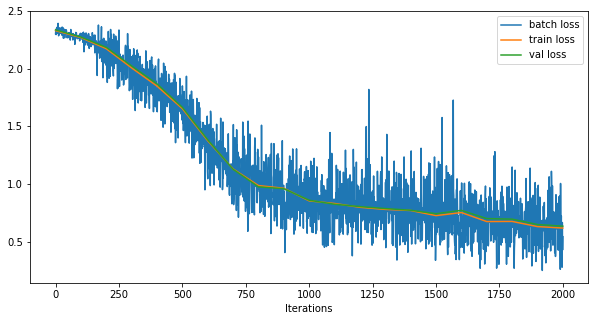

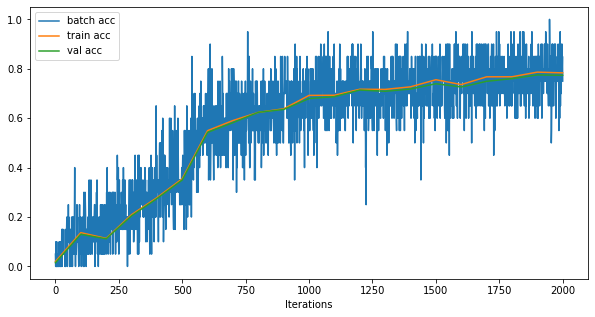

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(stats['batch_losss'],label='batch loss')
plt.plot(stats['check_its'],stats['train_losss'],label='train loss')
plt.plot(stats['check_its'],stats['val_losss'],label='val loss')
plt.xlabel('Iterations')
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(stats['batch_accs'],label='batch acc')
plt.plot(stats['check_its'],stats['train_accs'],label='train acc')
plt.plot(stats['check_its'],stats['val_accs'],label='val acc')
plt.xlabel('Iterations')
plt.legend()

## Compare training with different batch sizes

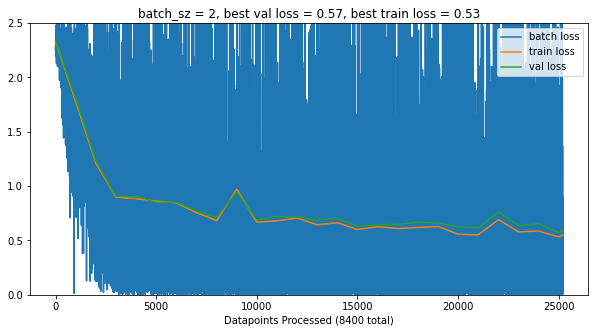

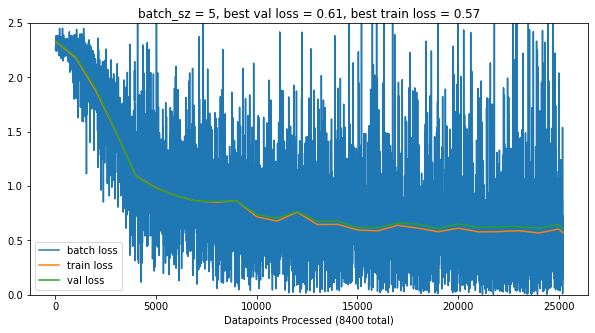

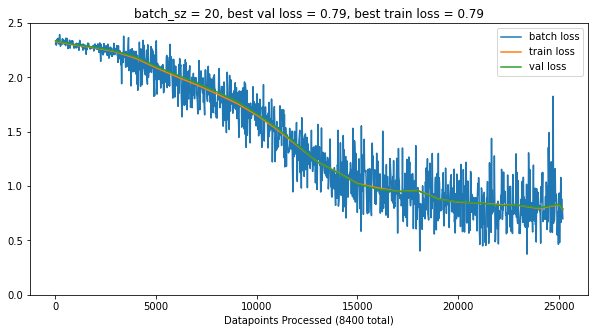

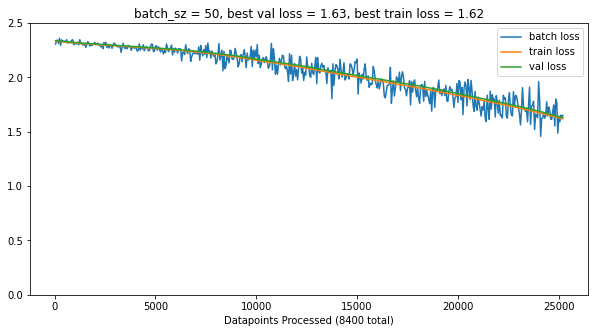

In [ ]:
opt_params = { 'epsilon0':1e-1, 'epsilon_decay':0.99999,
               'num_its':2001, 'check_freq':100, 'print_checks':False, 'Theta0':None }
arch_params = { 'num_hidden_layers':2, 'num_hidden_units':20, 'num_outs':num_classes,
                'act_func':relu, 'out_func':softmax, 'loss_func':crossent }

batch_sz_vals = [2, 5, 20, 50]

for trial,batch_sz in enumerate(batch_sz_vals):
  opt_params['batch_sz'] = batch_sz

  # Make ~3 passes through the training data
  opt_params['num_its'] = (3*train_x.shape[0])//batch_sz
  opt_params['check_freq'] = 1000//batch_sz
  opt_params['epsilon_decay'] = (0.99999)**(5.0/batch_sz)
  Theta_t, stats_t = nn_fit(train_x, train_y, val_x, val_y,
                            opt_params, arch_params)

  # Plot the loss curves as a function of data points processed
  plt.figure(figsize=(10,5))
  plt.plot(stats_t['data_pts'],stats_t['batch_losss'],label='batch loss')
  plt.plot(stats_t['check_data_pts'],stats_t['train_losss'],label='train loss')
  plt.plot(stats_t['check_data_pts'],stats_t['val_losss'],label='val loss')
  plt.xlabel('Datapoints Processed ({} total)'.format(train_x.shape[0]))
  plt.ylim(0,2.5)
  plt.title('batch_sz = {}, best val loss = {:.2f}, best train loss = {:.2f}'.format(batch_sz,np.min(stats_t['val_losss']),np.min(stats_t['train_losss'])))
  plt.legend()


## Compare training with different architectures

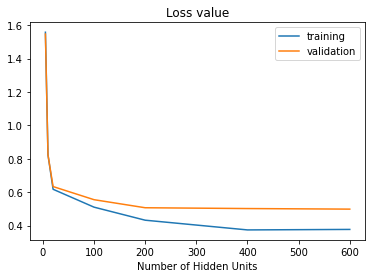

In [ ]:
opt_params = { 'batch_sz':20, 'epsilon0':1e-1, 'epsilon_decay':0.99999,
               'num_its':2001, 'check_freq':100, 'print_checks':False, 'Theta0':None }
arch_params = { 'num_hidden_layers':2, 'num_outs':num_classes,
                'act_func':relu, 'out_func':softmax, 'loss_func':crossent }

hidden_units_vals = [5,10,20,100,200,400,600]
final_val_loss = []
final_train_loss = []
for trial,hidden_units in enumerate(hidden_units_vals):
  arch_params['num_hidden_units'] = hidden_units

  Theta_t, stats_t = nn_fit(train_x, train_y, val_x, val_y,
                            opt_params, arch_params)
  
  final_val_loss.append(np.min(stats_t['val_losss']))
  final_train_loss.append(np.min(stats_t['train_losss']))
  

# plot the best validation and training losses as functions of # of hidden units
plt.figure()
plt.plot(hidden_units_vals, final_train_loss, label='training')
plt.plot(hidden_units_vals, final_val_loss, label='validation')
plt.xlabel('Number of Hidden Units')
plt.title('Loss value')
plt.legend()



## Do some hyperparameter architecture search

Place any code you use to do hyperparameter search below here.  You may add extra code blocks if you want or need.

Highest accuracy: 0.765 at 'number of hidden layers 1


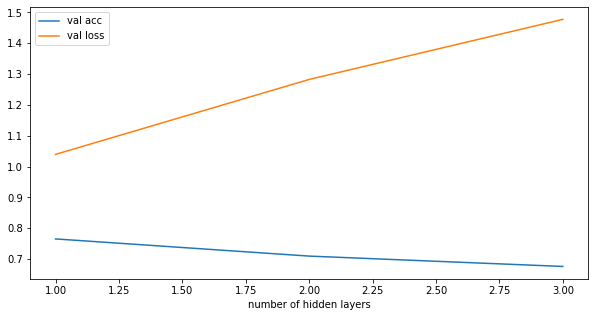

In [ ]:
# num_hidden_units ： 20
opt_params = { 'batch_sz':5, 'epsilon0':1e-1, 'epsilon_decay':0.99999,
               'num_its':2001, 'check_freq':100, 'print_checks':False, 'Theta0':None }
arch_params = { 'num_hidden_units':20, 'num_outs':num_classes,
                'act_func':relu, 'out_func':softmax, 'loss_func':crossent }

num_hidden_layers_vals = [1, 2, 3]
final_val_acc = []
avg_val_loss = []

for trial, num_hidden_layer in enumerate(num_hidden_layers_vals):
  arch_params['num_hidden_layers'] = num_hidden_layer
  # Make ~3 passes through the training data
  Theta_t, stats_t = nn_fit(train_x, train_y, val_x, val_y,
                            opt_params, arch_params)
  final_val_acc.append(stats_t['val_accs'][-1])
  avg_val_loss.append(np.average(stats_t['val_losss']))
  # Plot the loss curves as a function of data points processed

plt.figure(figsize=(10,5))
plt.plot(num_hidden_layers_vals,final_val_acc,label='val acc')
plt.plot(num_hidden_layers_vals,avg_val_loss,label='val loss')
plt.xlabel('number of hidden layers')
plt.legend()
print("Highest accuracy: {} at 'number of hidden layers {}".format(np.max(final_val_acc), num_hidden_layers_vals[np.argmax(final_val_acc)]))

Highest accuracy: 0.8069642857142857 at 'number of hidden units 400


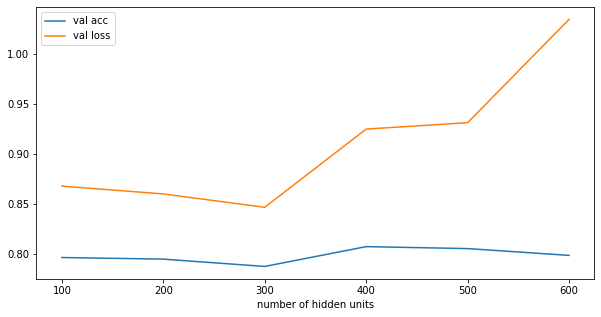

In [ ]:
# num_hidden_layers ： 1
opt_params = { 'batch_sz':5, 'epsilon0':1e-1, 'epsilon_decay':0.99999,
               'num_its':2001, 'check_freq':100, 'print_checks':False, 'Theta0':None }
arch_params = { 'num_hidden_layers':1, 'num_outs':num_classes,
                'act_func':relu, 'out_func':softmax, 'loss_func':crossent }

hidden_units_vals = [100,200,300,400,500,600]
final_val_acc = []
avg_val_loss = []

for trial, num_hidden_units in enumerate(hidden_units_vals):
  arch_params['num_hidden_units'] = num_hidden_units
  # Make ~3 passes through the training data
  Theta_t, stats_t = nn_fit(train_x, train_y, val_x, val_y,
                            opt_params, arch_params)
  final_val_acc.append(np.max(stats_t['val_accs'][-1]))
  avg_val_loss.append(np.average(stats_t['val_losss']))
  # Plot the loss curves as a function of data points processed

plt.figure(figsize=(10,5))
plt.plot(hidden_units_vals,final_val_acc,label='val acc')
plt.plot(hidden_units_vals,avg_val_loss,label='val loss')
plt.xlabel('number of hidden units')
plt.legend()
print("Highest accuracy: {} at 'number of hidden units {}".format(np.max(final_val_acc), hidden_units_vals[np.argmax(final_val_acc)]))

Highest accuracy: 0.8364285714285714 at batch size 5
num_its: 5040
check_freq: 200
epsilon_decay: 0.99999


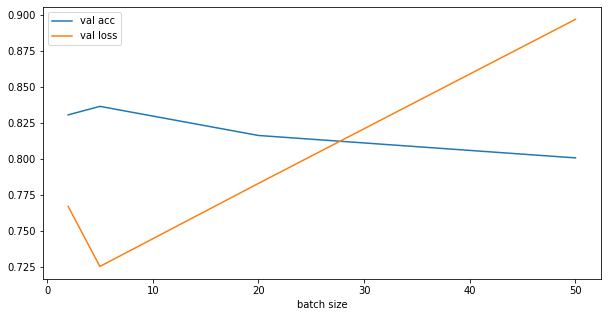

In [ ]:
# num_hidden_units ： 300
# num_hidden_layers': 1
opt_params = { 'epsilon0':1e-1, 'epsilon_decay':0.99999,
               'num_its':2001, 'check_freq':100, 'print_checks':False, 'Theta0':None }
arch_params = { 'num_hidden_layers':1, 'num_hidden_units':300, 'num_outs':num_classes,
                'act_func':relu, 'out_func':softmax, 'loss_func':crossent }

batch_sz_vals = [2, 5, 20, 50]
final_val_acc = []
avg_val_loss = []
for trial,batch_sz in enumerate(batch_sz_vals):
  opt_params['batch_sz'] = batch_sz

  # Make ~3 passes through the training data
  opt_params['num_its'] = (3*train_x.shape[0])//batch_sz
  opt_params['check_freq'] = 1000//batch_sz
  opt_params['epsilon_decay'] = (0.99999)**(5.0/batch_sz)
  Theta_t, stats_t = nn_fit(train_x, train_y, val_x, val_y,
                            opt_params, arch_params)
  final_val_acc.append(np.max(stats_t['val_accs']))
  avg_val_loss.append(np.average(stats_t['val_losss']))
  # Plot the loss curves as a function of data points processed

plt.figure(figsize=(10,5))
plt.plot(batch_sz_vals,final_val_acc,label='val acc')
plt.plot(batch_sz_vals,avg_val_loss,label='val loss')
plt.xlabel('batch size')
plt.legend()
batch_sz = batch_sz_vals[np.argmax(final_val_acc)]
print("Highest accuracy: {} at batch size {}".format(np.max(final_val_acc), batch_sz))

print("num_its: {}".format((3*train_x.shape[0])//batch_sz))
print("check_freq: {}".format( 1000//batch_sz))
print("epsilon_decay: {}".format((0.99999)**(5.0/batch_sz)))

Highest accuracy: 0.7885714285714286 at 'number of epsilon0 0.1


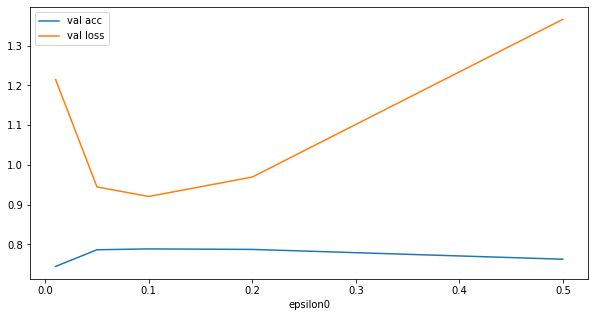

In [ ]:
# batch_sz : 5
# num_hidden_units ： 300
# num_hidden_layers': 1
# check_freq: 200
# epsilon_decay: 0.99999
opt_params = { 'batch_sz':5, 'epsilon0':1e-1, 'epsilon_decay':0.99999,
               'num_its':2001, 'check_freq':200, 'print_checks':False, 'Theta0':None }
arch_params = { 'num_hidden_layers':1, 'num_hidden_units':300, 'num_outs':num_classes,
                'act_func':relu, 'out_func':softmax, 'loss_func':crossent }

epsilon0_vals = [1e-2, 5e-2, 1e-1, 2e-1, 5e-1]
final_val_acc = []
avg_val_loss = []
for trial,epsilon0 in enumerate(epsilon0_vals):
  opt_params['epsilon0'] = epsilon0
  Theta_t, stats_t = nn_fit(train_x, train_y, val_x, val_y,
                            opt_params, arch_params)
  final_val_acc.append(np.max(stats_t['val_accs']))
  avg_val_loss.append(np.average(stats_t['val_losss']))
  # Plot the loss curves as a function of data points processed

plt.figure(figsize=(10,5))
plt.plot(epsilon0_vals,final_val_acc,label='val acc')
plt.plot(epsilon0_vals,avg_val_loss,label='val loss')
plt.xlabel('epsilon0')
plt.legend()
print("Highest accuracy: {} at 'number of epsilon0 {}".format(np.max(final_val_acc), epsilon0_vals[np.argmax(final_val_acc)]))

Highest accuracy: 0.8383928571428572 at iteration 6600


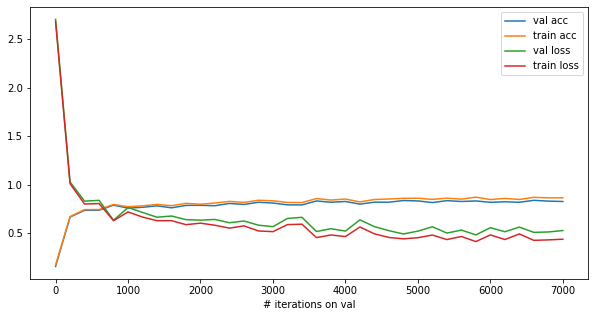

In [ ]:
# batch_sz : 5
# num_hidden_units ： 300
# num_hidden_layers : 1
# epsilon0 : 1e-1
# epsilon_decay : 0.99999

opt_params = { 'batch_sz':5, 'epsilon0':1e-1, 'epsilon_decay': 0.99999,
               'num_its': 7001, 'check_freq':200, 'print_checks':False, 'Theta0':None }
arch_params = { 'num_hidden_layers':1, 'num_hidden_units':300, 'num_outs':num_classes,
                'act_func':relu, 'out_func':softmax, 'loss_func':crossent }

avg_val_loss = []
Theta_t, stats_t = nn_fit(train_x, train_y, val_x, val_y,
                            opt_params, arch_params)
final_val_acc = stats_t['val_accs']
# Plot the loss curves as a function of data points processed

plt.figure(figsize=(10,5))
plt.plot(stats_t['check_its'],final_val_acc,label='val acc')
plt.plot(stats_t['check_its'],stats_t['train_accs'],label='train acc')
plt.plot(stats_t['check_its'],stats_t['val_losss'],label='val loss')
plt.plot(stats_t['check_its'],stats_t['train_losss'],label='train loss')
plt.xlabel('# iterations on val')
plt.legend()
print("Highest accuracy: {} at iteration {}".format(np.max(final_val_acc), stats_t['check_its'][np.argmax(final_val_acc)]))

In [ ]:
print(str(np.average(stats_t['val_accs'])))
print(str(np.average(stats_t['val_losss'])))
print(str(np.average(stats_t['train_accs'])))
print(str(np.average(stats_t['train_losss'])))

0.7825099206349206
0.6682038638608988
0.8054001322751323
0.610904178713389
